<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%load_ext autoreload
%autoreload 2

import os
import socket

repo_name = "DD2424-project"
dep_filename = "download_dataset.py"
cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

if os.path.exists(dep_filename):
    print(f"{dep_filename} is in your current directory. Assuming you are in the root of the repository.")
elif not os.path.exists(repo_name):
    print(f"Cloning repo and fetching {dep_filename}...")
    !git clone https://github.com/Sebelino/DD2424-project
    !cp DD2424-project/download_dataset.py .
else:
    !git -C DD2424-project pull --rebase
    !cp DD2424-project/download_dataset.py .

Host: deeplearning-vm
You are here: /home/silpasoninallacheruvu/DD2424-project
download_dataset.py is in your current directory. Assuming you are in the root of the repository.


# Train model

In [ ]:
from dataclasses import asdict
from util import json_dumps
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds, run_comparison
from run import run
%reload_ext autoreload
%autoreload 2

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import

from training import TrainParams, NagParams, AdamParams

baseline_params = TrainParams(
    seed=determinism.seed,
    batch_size=32,
    architecture="resnet50",
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.01,
        weight_decay=1e-4,
        momentum=0.9,
    ),
    freeze_layers=True,
    unfreezing_epochs=None,
    validation_freq=1,
    unfreeze_last_l_blocks = 1,
    time_limit_seconds=None,
    val_acc_target=None,
)

invalidate_cache_entry = True
if invalidate_cache_entry:
    run.call_and_shelve(baseline_params).clear()

# First plot: Training and validation accuracy
for l in range(1,6):
    baseline_params.unfreeze_last_l_blocks = l
    print("Training with params:")
    print(baseline_params.pprint())
    result = run(baseline_params)

    print("Training result:")
    print(result.pprint())
    evaluate_with_train_val_plot(result)

    # Second plot: Rerun training multiple times with different seed
    run_with_different_seeds(baseline_params, trials=3)

    # Third plot: Compare NAG with Adam
    experimental_params = baseline_params.copy()
    experimental_params.optimizer = AdamParams(learning_rate=0.001)
    
    param_sets = {
        "Baseline (NAG)": baseline_params,
        "Experiment (Adam)": experimental_params,
    }
    
    run_comparison(param_sets, trials=3)


# Train unsupervised model

labelled_data_fraction: 0.1
Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.022630885203465553,
    "weight_decay": 8.478660307897792e-05,
    "momentum": 0.8063799868511693,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "unfreeze_last_l_blocks": 3,
  "unsup_weight": 0.5,
  "psuedo_threshold": 0.95
}
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/10], Loss: 3.3760, Train Acc: 15.31%, Val Acc: 47.69%
Epoch [2/10], Loss: 2.3044, Train Acc: 62.24%, Val Acc: 66.17%
Epoch [3/10], Loss: 1.2688, Train Acc: 82.65%, Val Acc: 57.47%
Epoch [4/10], Loss: 0.8910, Train Acc: 86.05%, Val Acc: 77.99%
Epoch [5/10], Loss: 0.2823, Train Acc: 95.58%, Val Acc: 79.48%
Epoch [6/10], Loss: 0.1614, Train Acc: 97.28%, Val Acc: 70.38%
Epoch [7/10], Loss: 0.4080, Train Acc: 91.50%, Val Acc: 74.18%
Epoch [8/10], Loss: 0.2215, Train Acc: 97.62%, Val Acc: 61.68%
Epoch [9/10], Loss: 0.1371, Train Acc: 97.62%, Val Acc: 78.26%
Epoch [10/10], Loss: 0.0449, Train Acc: 100.00%, Val Acc: 78.53%
Total elapsed: 56.12s, average per update step: 0.26s
Training result:
{
  "training_losses": [3.376017355918884, 2.3043954968452454, 1.2688264161348344, 0.890966191701591, 0.2823414897546172, 0.1613638626411557, 0.40803773924708364, 0.22147598918527364, 0.13709729481488467, 0.04488726817071438],
  "training_accuracies": [0.15306122448979592, 0.6224489795918368, 0.8

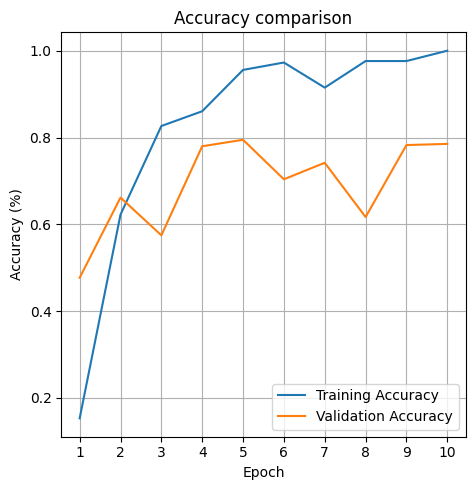

labelled_data_fraction: 0.3
Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.022630885203465553,
    "weight_decay": 8.478660307897792e-05,
    "momentum": 0.8063799868511693,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "unfreeze_last_l_blocks": 3,
  "unsup_weight": 0.5,
  "psuedo_threshold": 0.95
}
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.6712, Train Acc: 48.24%, Val Acc: 79.48%
Epoch [2/10], Loss: 1.0239, Train Acc: 80.97%, Val Acc: 78.40%
Epoch [3/10], Loss: 0.3223, Train Acc: 92.07%, Val Acc: 87.91%
Epoch [4/10], Loss: 0.0721, Train Acc: 98.75%, Val Acc: 89.13%
Epoch [5/10], Loss: 0.0508, Train Acc: 98.64%, Val Acc: 88.72%
Epoch [6/10], Loss: 0.0158, Train Acc: 99.89%, Val Acc: 90.76%
Epoch [7/10], Loss: 0.0147, Train Acc: 99.89%, Val Acc: 89.67%
Epoch [8/10], Loss: 0.0066, Train Acc: 100.00%, Val Acc: 90.35%
Epoch [9/10], Loss: 0.0060, Train Acc: 100.00%, Val Acc: 91.44%
Epoch [10/10], Loss: 0.0061, Train Acc: 100.00%, Val Acc: 89.27%
Total elapsed: 99.06s, average per update step: 0.25s
Training result:
{
  "training_losses": [2.6711506630693163, 1.0238954149120088, 0.32225932751316577, 0.07210855336493946, 0.05082384289042758, 0.015751573934851746, 0.014654593517272068, 0.006578151113769438, 0.006012795133366515, 0.006140667761168775],
  "training_accuracies": [0.4824462061155153, 0.809739524

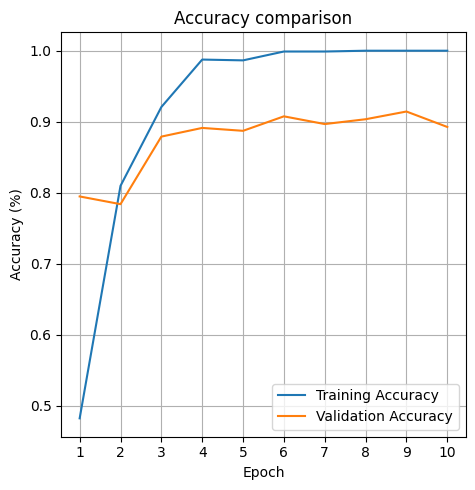

labelled_data_fraction: 0.5
Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.022630885203465553,
    "weight_decay": 8.478660307897792e-05,
    "momentum": 0.8063799868511693,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "unfreeze_last_l_blocks": 3,
  "unsup_weight": 0.5,
  "psuedo_threshold": 0.95
}
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/460 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.1246, Train Acc: 63.52%, Val Acc: 86.28%
Epoch [2/10], Loss: 0.6862, Train Acc: 85.60%, Val Acc: 80.30%
Epoch [3/10], Loss: 0.1734, Train Acc: 95.45%, Val Acc: 86.41%
Epoch [4/10], Loss: 0.0788, Train Acc: 98.17%, Val Acc: 86.96%
Epoch [5/10], Loss: 0.0371, Train Acc: 99.12%, Val Acc: 90.08%
Epoch [6/10], Loss: 0.0253, Train Acc: 99.39%, Val Acc: 88.99%
Epoch [7/10], Loss: 0.0121, Train Acc: 99.93%, Val Acc: 91.03%
Epoch [8/10], Loss: 0.0161, Train Acc: 99.73%, Val Acc: 91.98%
Epoch [9/10], Loss: 0.0228, Train Acc: 99.32%, Val Acc: 91.85%
Epoch [10/10], Loss: 0.0180, Train Acc: 99.52%, Val Acc: 93.07%
Total elapsed: 142.52s, average per update step: 0.26s
Training result:
{
  "training_losses": [2.1245841241401173, 0.6862197708561206, 0.17338897292400993, 0.07879608791604963, 0.037109377935690725, 0.025316903718149937, 0.012117918279609117, 0.016100992251228054, 0.02278796068719163, 0.017989708430832252],
  "training_accuracies": [0.6351902173913043, 0.85597826086

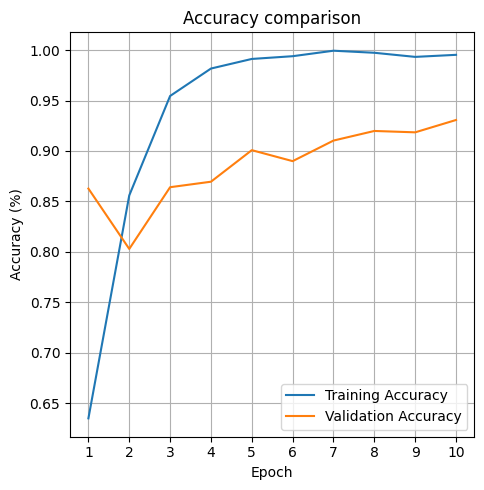

labelled_data_fraction: 0.7
Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.022630885203465553,
    "weight_decay": 8.478660307897792e-05,
    "momentum": 0.8063799868511693,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "unfreeze_last_l_blocks": 3,
  "unsup_weight": 0.5,
  "psuedo_threshold": 0.95
}
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/650 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.7914, Train Acc: 68.54%, Val Acc: 87.36%
Epoch [2/10], Loss: 0.5080, Train Acc: 86.41%, Val Acc: 84.92%
Epoch [3/10], Loss: 0.1798, Train Acc: 95.29%, Val Acc: 88.45%
Epoch [4/10], Loss: 0.0852, Train Acc: 97.38%, Val Acc: 90.76%
Epoch [5/10], Loss: 0.0281, Train Acc: 99.32%, Val Acc: 93.21%
Epoch [6/10], Loss: 0.0105, Train Acc: 99.90%, Val Acc: 93.48%
Epoch [7/10], Loss: 0.0115, Train Acc: 99.71%, Val Acc: 92.26%
Epoch [8/10], Loss: 0.0089, Train Acc: 99.90%, Val Acc: 91.17%
Epoch [9/10], Loss: 0.0178, Train Acc: 99.66%, Val Acc: 92.39%
Epoch [10/10], Loss: 0.0217, Train Acc: 99.37%, Val Acc: 91.71%
Total elapsed: 189.67s, average per update step: 0.26s
Training result:
{
  "training_losses": [1.7913817882537841, 0.5080039009881707, 0.1797937272188182, 0.08517845203885092, 0.02807007671172659, 0.010450444796319621, 0.011525848973318577, 0.00889722880517813, 0.01776325381405723, 0.021699848839153463],
  "training_accuracies": [0.6854368932038835, 0.86407766990291

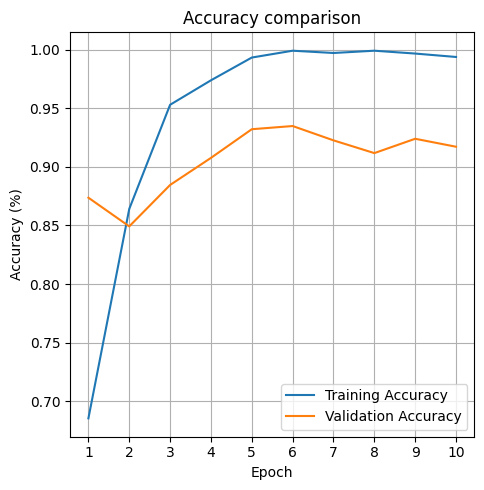

labelled_data_fraction: 0.9
Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.022630885203465553,
    "weight_decay": 8.478660307897792e-05,
    "momentum": 0.8063799868511693,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "unfreeze_last_l_blocks": 3,
  "unsup_weight": 0.5,
  "psuedo_threshold": 0.95
}
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.6094, Train Acc: 72.33%, Val Acc: 86.28%
Epoch [2/10], Loss: 0.4995, Train Acc: 86.37%, Val Acc: 85.87%
Epoch [3/10], Loss: 0.1246, Train Acc: 96.30%, Val Acc: 91.71%
Epoch [4/10], Loss: 0.0487, Train Acc: 98.72%, Val Acc: 93.75%
Epoch [5/10], Loss: 0.0211, Train Acc: 99.51%, Val Acc: 91.58%
Epoch [6/10], Loss: 0.0261, Train Acc: 99.36%, Val Acc: 92.53%
Epoch [7/10], Loss: 0.0195, Train Acc: 99.51%, Val Acc: 92.93%
Epoch [8/10], Loss: 0.0076, Train Acc: 99.92%, Val Acc: 93.48%
Epoch [9/10], Loss: 0.0200, Train Acc: 99.43%, Val Acc: 92.12%
Epoch [10/10], Loss: 0.0111, Train Acc: 99.81%, Val Acc: 91.71%
Total elapsed: 232.16s, average per update step: 0.27s
Training result:
{
  "training_losses": [1.6093712298266858, 0.4994932526458863, 0.12455556421759482, 0.04866143911010978, 0.021065064292844295, 0.026108700555541653, 0.01951336575035954, 0.00760918173874821, 0.019969978525811043, 0.011117798461037385],
  "training_accuracies": [0.7232918082295205, 0.863722159305

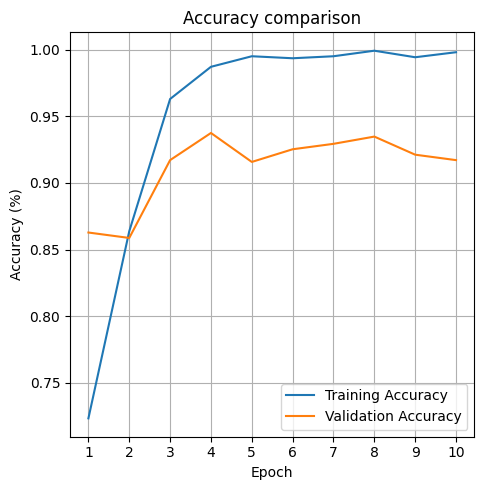

labelled_data_fraction: 1.0
Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.022630885203465553,
    "weight_decay": 8.478660307897792e-05,
    "momentum": 0.8063799868511693,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "unfreeze_last_l_blocks": 3,
  "unsup_weight": 0.5,
  "psuedo_threshold": 0.95
}
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/920 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.4610, Train Acc: 75.14%, Val Acc: 90.22%
Epoch [2/10], Loss: 0.2780, Train Acc: 91.30%, Val Acc: 89.95%
Epoch [3/10], Loss: 0.0799, Train Acc: 98.00%, Val Acc: 93.07%
Epoch [4/10], Loss: 0.0280, Train Acc: 99.52%, Val Acc: 93.75%
Epoch [5/10], Loss: 0.0125, Train Acc: 99.93%, Val Acc: 94.84%
Epoch [6/10], Loss: 0.0109, Train Acc: 99.83%, Val Acc: 94.29%
Epoch [7/10], Loss: 0.0083, Train Acc: 99.93%, Val Acc: 94.57%
Epoch [8/10], Loss: 0.0035, Train Acc: 100.00%, Val Acc: 95.38%
Epoch [9/10], Loss: 0.0032, Train Acc: 100.00%, Val Acc: 95.79%
Epoch [10/10], Loss: 0.0028, Train Acc: 100.00%, Val Acc: 95.24%
Total elapsed: 141.69s, average per update step: 0.11s
Training result:
{
  "training_losses": [1.460982531633066, 0.2779818507640258, 0.07993904840322616, 0.027999853897515848, 0.012498561038544563, 0.010852517055236209, 0.008264193741564193, 0.0034710474504643807, 0.0032453711648248946, 0.0027737162036709892],
  "training_accuracies": [0.751358695652174, 0.91304

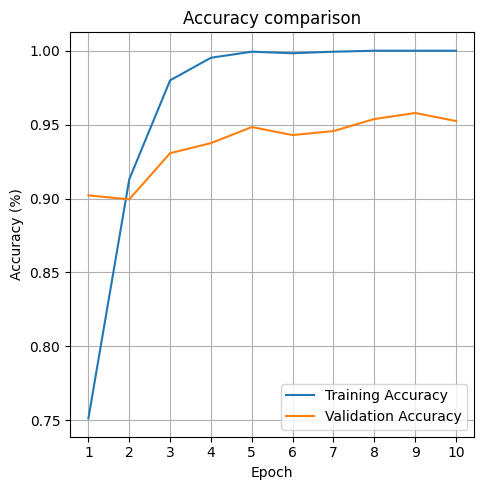

In [6]:
%reload_ext autoreload
%autoreload 2

from training import TrainParams, NagParams
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds, run_comparison
from run import run
from caching import invalidate_cache_entry
from datasets import DatasetParams

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import


dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    trainval_size=None,  # Load all training data
    #trainval_size=400,  # Load a subset
    validation_set_fraction=0.2,  # 20 % of trainval set
    labelled_data_fraction=1, # full labelled data first
)

baseline_params = TrainParams(
    seed=determinism.seed,
    architecture="resnet50",
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.022630885203465553,
        weight_decay=8.478660307897792e-05,
        momentum=0.8063799868511693,
    ),
    freeze_layers=True,
    unfreezing_epochs=(2, 4),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
    unfreeze_last_l_blocks = 3
)

for i in range(1,12,2):
    labelled_data_fraction = min(i/10, 1.0)
    print(f"labelled_data_fraction: {labelled_data_fraction}")
    dataset_params.labelled_data_fraction = labelled_data_fraction

    run_args = (dataset_params, baseline_params)
    
    # Set invalidate=True to invalidate a single cache entry
    invalidate_cache_entry(run, run_args, invalidate=False)
    
    # First plot: Training and validation accuracy
    print("Training with params:")
    print(baseline_params.pprint())
    result = run(*run_args)
    
    print("Training result:")
    print(result.pprint())
    evaluate_with_train_val_plot(result)

[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/10], Loss: 3.3502, Train Acc: 19.73%, Val Acc: 49.32%
Epoch [2/10], Loss: 2.2788, Train Acc: 66.33%, Val Acc: 64.81%
Epoch [3/10], Loss: 1.3661, Train Acc: 81.63%, Val Acc: 54.76%
Epoch [4/10], Loss: 0.8427, Train Acc: 85.71%, Val Acc: 79.48%
Epoch [5/10], Loss: 0.2846, Train Acc: 95.58%, Val Acc: 74.59%
Epoch [6/10], Loss: 0.1407, Train Acc: 97.96%, Val Acc: 73.78%
Epoch [7/10], Loss: 0.1244, Train Acc: 98.30%, Val Acc: 76.49%
Epoch [8/10], Loss: 0.1382, Train Acc: 99.32%, Val Acc: 76.36%
Epoch [9/10], Loss: 0.0823, Train Acc: 98.64%, Val Acc: 78.12%
Epoch [10/10], Loss: 0.0378, Train Acc: 99.32%, Val Acc: 79.21%
Total elapsed: 53.42s, average per update step: 0.26s
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.6773, Train Acc: 48.36%, Val Acc: 79.89%
Epoch [2/10], Loss: 0.9932, Train Acc: 81.43%, Val Acc: 80.84%
Epoch [3/10], Loss: 0.3257, Train Acc: 91.28%, Val Acc: 83.70%
Epoch [4/10], Loss: 0.1049, Train Acc: 97.62%, Val Acc: 87.50%
Epoch [5/10], Loss: 0.0405, Train Acc: 99.21%, Val Acc: 88.99%
Epoch [6/10], Loss: 0.0234, Train Acc: 99.55%, Val Acc: 90.22%
Epoch [7/10], Loss: 0.0323, Train Acc: 99.43%, Val Acc: 89.81%
Epoch [8/10], Loss: 0.0086, Train Acc: 99.89%, Val Acc: 90.35%
Epoch [9/10], Loss: 0.0143, Train Acc: 99.55%, Val Acc: 90.76%
Epoch [10/10], Loss: 0.0063, Train Acc: 99.89%, Val Acc: 90.49%
Total elapsed: 96.95s, average per update step: 0.25s
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/460 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.1405, Train Acc: 61.82%, Val Acc: 87.09%
Epoch [2/10], Loss: 0.6986, Train Acc: 84.31%, Val Acc: 79.89%
Epoch [3/10], Loss: 0.1889, Train Acc: 95.18%, Val Acc: 83.56%
Epoch [4/10], Loss: 0.0834, Train Acc: 97.96%, Val Acc: 91.58%
Epoch [5/10], Loss: 0.0504, Train Acc: 98.91%, Val Acc: 92.12%
Epoch [6/10], Loss: 0.0242, Train Acc: 99.59%, Val Acc: 92.66%
Epoch [7/10], Loss: 0.0165, Train Acc: 99.73%, Val Acc: 92.66%
Epoch [8/10], Loss: 0.0069, Train Acc: 99.93%, Val Acc: 92.12%
Epoch [9/10], Loss: 0.0046, Train Acc: 100.00%, Val Acc: 92.93%
Epoch [10/10], Loss: 0.0030, Train Acc: 100.00%, Val Acc: 92.80%
Total elapsed: 141.56s, average per update step: 0.26s
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/650 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.7855, Train Acc: 68.69%, Val Acc: 87.50%
Epoch [2/10], Loss: 0.5079, Train Acc: 86.84%, Val Acc: 85.60%
Epoch [3/10], Loss: 0.1860, Train Acc: 94.56%, Val Acc: 89.13%
Epoch [4/10], Loss: 0.0536, Train Acc: 98.74%, Val Acc: 90.62%
Epoch [5/10], Loss: 0.0462, Train Acc: 98.83%, Val Acc: 90.22%
Epoch [6/10], Loss: 0.0333, Train Acc: 99.27%, Val Acc: 91.98%
Epoch [7/10], Loss: 0.0164, Train Acc: 99.61%, Val Acc: 92.26%
Epoch [8/10], Loss: 0.0099, Train Acc: 99.90%, Val Acc: 91.71%
Epoch [9/10], Loss: 0.0174, Train Acc: 99.66%, Val Acc: 92.26%
Epoch [10/10], Loss: 0.0067, Train Acc: 99.90%, Val Acc: 90.90%
Total elapsed: 188.39s, average per update step: 0.27s
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.6051, Train Acc: 71.80%, Val Acc: 86.41%
Epoch [2/10], Loss: 0.5049, Train Acc: 86.60%, Val Acc: 87.50%
Epoch [3/10], Loss: 0.1027, Train Acc: 96.83%, Val Acc: 93.07%
Epoch [4/10], Loss: 0.0435, Train Acc: 98.91%, Val Acc: 91.71%
Epoch [5/10], Loss: 0.0314, Train Acc: 99.28%, Val Acc: 91.98%
Epoch [6/10], Loss: 0.0242, Train Acc: 99.32%, Val Acc: 92.39%
Epoch [7/10], Loss: 0.0114, Train Acc: 99.74%, Val Acc: 93.34%
Epoch [8/10], Loss: 0.0054, Train Acc: 99.89%, Val Acc: 91.44%
Epoch [9/10], Loss: 0.0053, Train Acc: 99.92%, Val Acc: 93.61%
Epoch [10/10], Loss: 0.0059, Train Acc: 99.77%, Val Acc: 91.98%
Total elapsed: 231.22s, average per update step: 0.26s
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/920 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.4605, Train Acc: 75.03%, Val Acc: 90.08%
Epoch [2/10], Loss: 0.2736, Train Acc: 92.02%, Val Acc: 89.40%
Epoch [3/10], Loss: 0.0781, Train Acc: 97.89%, Val Acc: 93.34%
Epoch [4/10], Loss: 0.0271, Train Acc: 99.63%, Val Acc: 94.16%
Epoch [5/10], Loss: 0.0140, Train Acc: 99.80%, Val Acc: 94.70%
Epoch [6/10], Loss: 0.0097, Train Acc: 99.86%, Val Acc: 94.70%
Epoch [7/10], Loss: 0.0090, Train Acc: 99.86%, Val Acc: 94.70%
Epoch [8/10], Loss: 0.0060, Train Acc: 99.93%, Val Acc: 95.11%
Epoch [9/10], Loss: 0.0049, Train Acc: 99.93%, Val Acc: 94.57%
Epoch [10/10], Loss: 0.0033, Train Acc: 100.00%, Val Acc: 94.84%
Total elapsed: 139.48s, average per update step: 0.12s


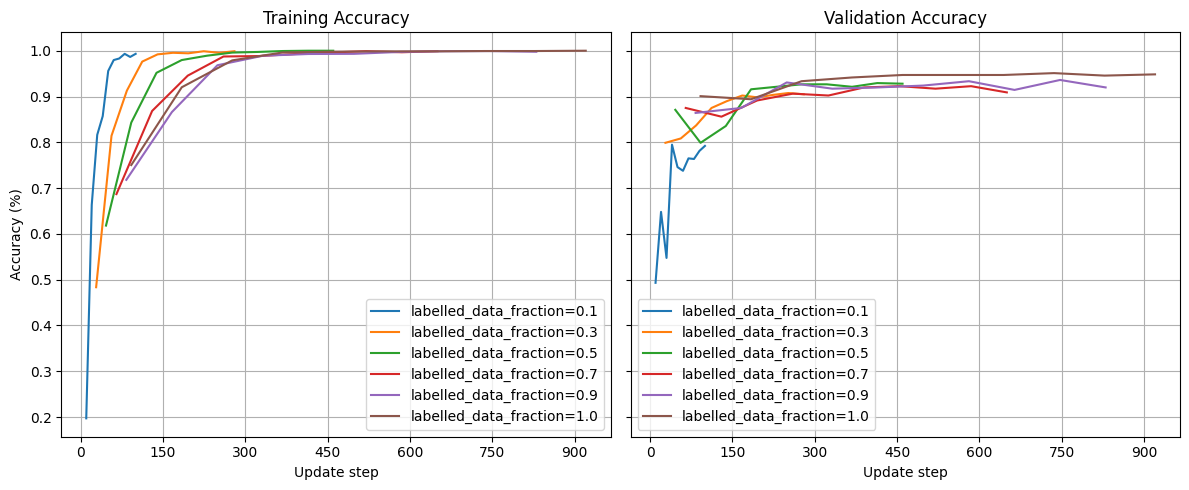

In [14]:
from evaluation import run_dataset_comparison
def tweak(params: DatasetParams, labelled_data_fraction):
    params = params.copy()
    params.labelled_data_fraction = labelled_data_fraction
    return params


#plot: Compare unsupervised learning for different fractions of unlabelled data
labelled_data_fractions = [ 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
param_sets = {f"labelled_data_fraction={data_fraction}": tweak(dataset_params, labelled_data_fraction=data_fraction) for data_fraction in labelled_data_fractions}

run_dataset_comparison(param_sets, baseline_params)


# Test model

In [8]:
from training import FinishedAllEpochs, Trainer
from datasets import make_datasets, load_dataset
from torch.utils.data import DataLoader

training_params = baseline_params

print("Training with params:")
print(training_params.pprint())
trainer = Trainer(training_params)
labelled_train_loader, unlabelled_train_loader, val_loader = make_datasets(dataset_params, trainer.transform)
trainer.load(labelled_train_loader, unlabelled_train_loader, val_loader)
trainer.train(stop_condition=FinishedAllEpochs())

training_params.data_augmentation = "false"
test_dataset = load_dataset("test", Trainer.make_transform(training_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    worker_init_fn=Determinism.data_loader_worker_init_fn(training_params.seed),
)
print(f"Test size: {len(test_loader.dataset)}")

evaluate_test_accuracy_and_misclassified(trainer, test_loader, test_dataset)

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.022630885203465553,
    "weight_decay": 8.478660307897792e-05,
    "momentum": 0.8063799868511693,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "unfreeze_last_l_blocks": 3,
  "unsup_weight": 0.5,
  "psuedo_threshold": 0.95
}
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/920 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.4607, Train Acc: 74.86%, Val Acc: 90.08%
Epoch [2/10], Loss: 0.2794, Train Acc: 91.37%, Val Acc: 90.76%
Epoch [3/10], Loss: 0.0781, Train Acc: 97.86%, Val Acc: 93.61%
Epoch [4/10], Loss: 0.0277, Train Acc: 99.56%, Val Acc: 93.61%
Epoch [5/10], Loss: 0.0152, Train Acc: 99.76%, Val Acc: 94.97%
Epoch [6/10], Loss: 0.0100, Train Acc: 99.83%, Val Acc: 95.11%
Epoch [7/10], Loss: 0.0093, Train Acc: 99.86%, Val Acc: 95.11%
Epoch [8/10], Loss: 0.0038, Train Acc: 100.00%, Val Acc: 95.65%
Epoch [9/10], Loss: 0.0044, Train Acc: 99.93%, Val Acc: 94.84%
Epoch [10/10], Loss: 0.0036, Train Acc: 99.97%, Val Acc: 95.24%
Total elapsed: 140.27s, average per update step: 0.11s


NameError: name 'DataLoader' is not defined